# Lab of computational physics - EXR09

#### Barone Francesco Pio, AY 2021/22 UniPD

In [1]:
# I will place the files for this notebook in a dedicated subdirectory
%cd ./09data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy import fftpack
from scipy.fftpack import fft2, ifft2
from matplotlib.colors import LogNorm

/home/baronefr/Documents/lab_local/09data


1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [2]:
x0, mu = 15, 6.3  # x0 is the value to test, mu the average of hurricanes
sigma = np.sqrt(mu)  # sigma is fixed from Poisson distribution with mean mu

# compute the Z score
Z = abs(x0 - mu) / sigma
print("Z =", Z)

# calculate the p-value as the sum of the left tail + the right tail
pvalue = stats.norm.cdf(-Z) + (1. - stats.norm.cdf(Z))
print(" > p-value =", pvalue)

if pvalue < 0.05: print(f'value {x0} is statistically significant')
else: print(f'tested value is not statistically significant')

Z = 3.4661629670697414
 > p-value = 0.0005279431738299246
value 15 is statistically significant


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [3]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
n = len(pre)

# computing the means and variations (sigma squares)
pre_mean = np.mean(pre);  post_mean = np.mean(post);
pre_var = np.var(pre);  post_var = np.var(post);

# computing the requested statistics
sigma = np.sqrt( (pre_var + post_var)/2 )
T = ( pre_mean - post_mean )*np.sqrt(2/n)/ sigma
#     ^ new samples    ^ previous samples
print('T =',T)

pvalue = stats.t.cdf(T, n - 1) + (1. - stats.t.cdf(-T, n - 1))
print('p-value =', pvalue)

if pvalue < 0.05/2: print(f' > the new data is statistically significant')
else: print(f' > the new data is not statistically significant')

T = -0.7983692652584224
p-value = 0.44521126498533986
 > the new data is not statistically significant


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

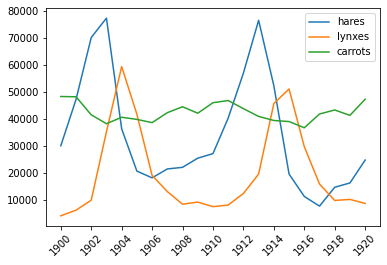

population: hares
mean 34080.95238095238, std 20897.906458089667

population: lynxes
mean 20166.666666666668, std 16254.591536908763

population: carrots
mean 42400.0, std 3322.5062255844787



In [4]:
! wget -q -nc https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt

# recalling the code from Lab 3 exercises:

content = np.loadtxt('populations.txt')

#selecting data from the file
years = content[..., 0].astype(int)
species = {
  "hares": content[..., 1],
  "lynxes": content[..., 2],
  "carrots": content[..., 3] }
species_keys = list(species.keys())

# plot the populations
plt.plot(years, species['hares'], label='hares')
plt.plot(years, species['lynxes'], label='lynxes')
plt.plot(years, species['carrots'], label='carrots')
plt.xticks(years[::2], rotation=45)
plt.legend(loc="upper right")
plt.show()

# compute some statitics
for pid in species_keys:
    print(f'population: {pid}');    d = species[pid];
    print(f'mean {np.mean(d)}, std {np.std(d)}\n')

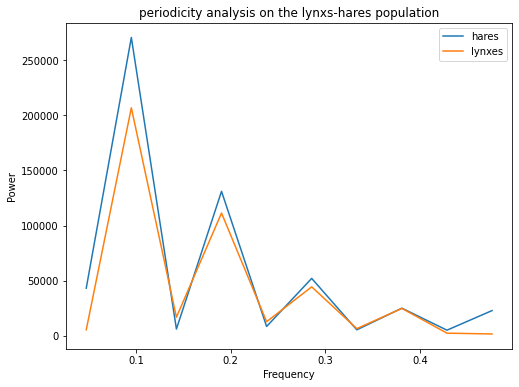

 hares freq: 0.09523809523809523 1/year
 -> hares period: 10.5 years
 lynxes freq: 0.09523809523809523 1/year
 -> lynxes period: 10.5 years


In [5]:
def perform_frequency_analysis(sig, label=None):
    # the FFT of the signal
    sig_fft = fftpack.fft( sig )

    # the power
    sample_power = np.abs(sig_fft)

    # back to the corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size, d=1)

    # focus only on positive frequencies
    freqs = sample_freq[sample_freq > 0]
    powers = sample_power[sample_freq > 0]

    # plot the power of frequencies
    if label is not None:
        plt.plot(freqs, powers, label=label)
    else:
        plt.plot(freqs, powers)
    plt.xlabel('Frequency')
    plt.ylabel('Power')

    # find the max of freqs array
    return freqs[powers.argmax()]

plt.figure(figsize=(8, 6))
hare_freq = perform_frequency_analysis(species['hares'], 'hares')
lynx_freq = perform_frequency_analysis(species['lynxes'], 'lynxes')
plt.legend()
plt.title('periodicity analysis on the lynxs-hares population')
plt.show()

print(f' hares freq: {hare_freq} 1/year')
print(f' -> hares period: {1/hare_freq} years')
print(f' lynxes freq: {lynx_freq} 1/year')
print(f' -> lynxes period: {1/lynx_freq} years')

From the Fourier analysis we notice that the period of lynxes and hares are comparable ($\leftarrow$ they are correlated, as we have seen in a previous assignment).

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

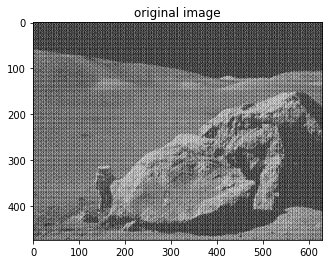

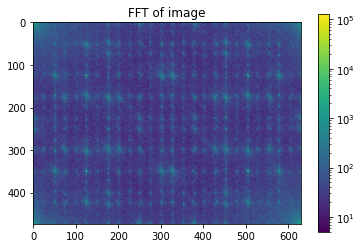

In [6]:
# plotting the original image
image = plt.imread("moonlanding.png")
plt.imshow(image, plt.cm.gray)
plt.title('original image')
plt.show()

# compute & plot the FFT
fft_image = fft2(image)
plt.imshow( np.abs(fft_image), norm=LogNorm(vmin=5))
plt.title('FFT of image')
plt.colorbar()
plt.show()

99.95 percentile: 1996.673828125


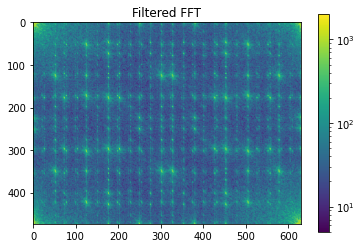

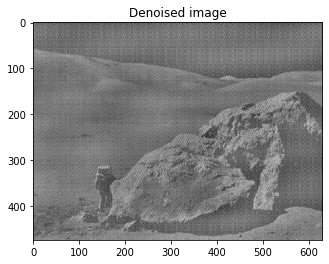

In [7]:
# filter on FFT
fft_power = np.abs(fft_image)
filtered = fft_image.copy()  # don't edit the original image

percentile_to_keep = 99.95
print(f'{percentile_to_keep} percentile:', np.percentile(fft_power, percentile_to_keep))
filtered[ fft_power > np.percentile(fft_power, percentile_to_keep) ] = 0 # suppress all the values above chosen percentile
# observation: other criteria can be applied to filter the noise

plt.imshow( np.abs(filtered), norm=LogNorm(vmin=5))
plt.title('Filtered FFT')
plt.colorbar()
plt.show()

# reconstruct the image (invert fft) ...
image_denoised = ifft2(filtered).real

# ... plot it
plt.figure()
plt.imshow(image_denoised , plt.cm.gray)
plt.title('Denoised image')
plt.show()

Other techniques can be applied to crop the noise in the Fourier domain. The resulting image will have a different degree of noise according to the chosen criteria.

End of file